# Transfer Learning

In [1]:
%matplotlib inline

import torch
import torch.nn.functional as F
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torchbearer
from torchbearer import Trial
from torch import optim
from torchbearer.callbacks import LiveLossPlot
import torch.optim as optim
from torchvision.models import resnet50
from urllib.request import urlopen
from PIL import Image as PImage

In [2]:
# the no. of images that will be processed in a single step
batch_size = 128

# the size of the images that we'll learn on 
# (we'll shrink them from the original size for speed)
image_size = (30, 100)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

train_dataset = ImageFolder('data/train', transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder('data/train', transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder('data/test', transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Methodology 1: Finetuning

We apply a smaller learning rate and further train the whole network on our own dataset.

In [3]:
model = resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

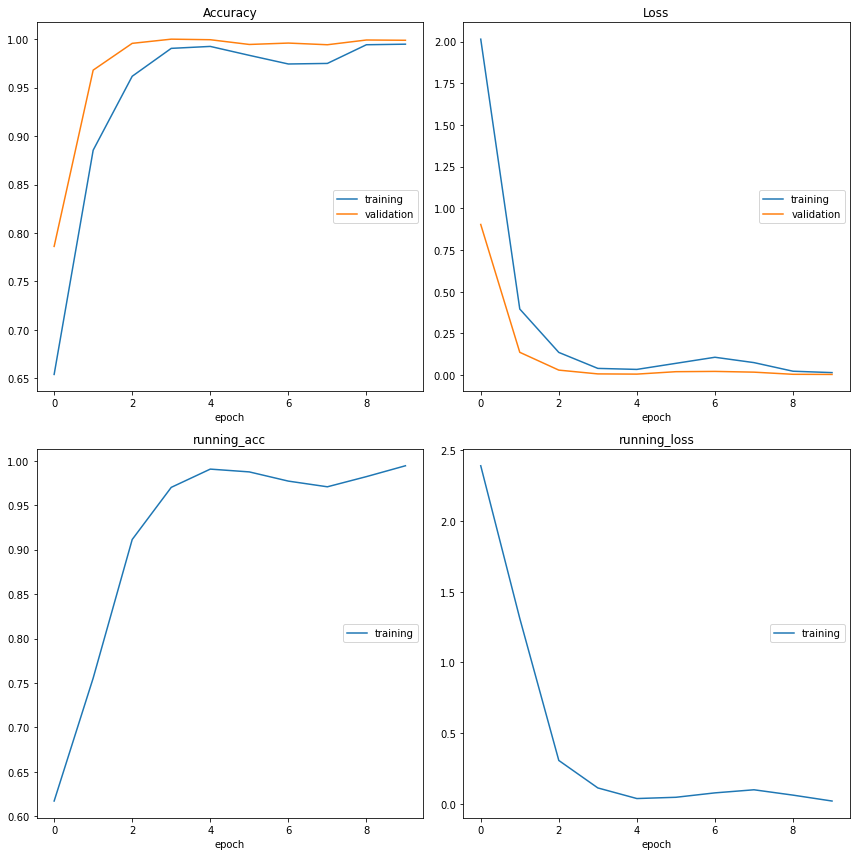

Wall time: 5min 48s


In [5]:
%%time

# we train all network params with a v. small lr
optimiser = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

trial = Trial(model, optimiser, loss_function,
              metrics=['loss', 'accuracy'],
              callbacks=[LiveLossPlot()]).to(device)

trial.with_generators(train_loader, 
                      val_generator=val_loader,
                      test_generator=test_loader)

history = trial.run(epochs=10)

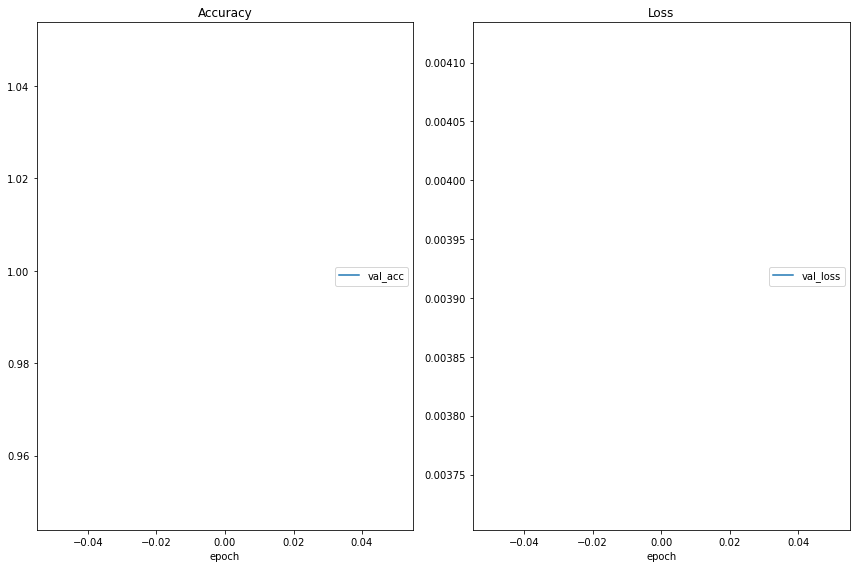


{'val_loss': 0.003918565809726715, 'val_acc': 0.9988486170768738}


In [8]:
results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print()
print(results)

## Methodology 2: Feature extraction

We start with a pretrained model and only update the final layer weights from which we derive predictions.